Source: https://pub.aimind.so/credit-card-fraud-detection-using-tensor-flow-2-0-fcc6859ea4e9

Jira: https://laiminhthong1.atlassian.net/jira/core/projects/CCTFDUX/board

Github Repos: https://github.com/ThongLai/Credit-Card-Transaction-Fraud-Detection-Using-Explainable-AI

Main Dataset: https://www.kaggle.com/datasets/kartik2112/fraud-detection/data

In [37]:
import sys
import os

# Check Python version
print(f"Python Version: `{sys.version}`")  # Detailed version info
print(f"Base Python location: `{sys.base_prefix}`")
print(f"Current Environment location: `{os.path.basename(sys.prefix)}`", end='\n\n')

import tensorflow as tf
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.config import list_physical_devices

print(f"Tensorflow version: `{tf.__version__}`")
print(f"CUDNN version: `{tf_build_info.build_info['cudnn_version']}`")
print(f"CUDA version: `{tf_build_info.build_info['cuda_version']}`")
print(f"Num GPUs Available: {len(list_physical_devices('GPU'))}")

Python Version: `3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]`
Base Python location: `C:\Users\LMT\AppData\Local\Programs\Python\Python310`
Current Environment location: `.venv_xai_fraud_detection`

Tensorflow version: `2.10.1`
CUDNN version: `64_8`
CUDA version: `64_112`
Num GPUs Available: 1


<a href="https://colab.research.google.com/github/siddharthapramanik771/CreditCardFraudDetectionML/blob/main/Credit_card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the necessary packages 

In [38]:
# %pip install tensorflow==2.10.1 numpy=1.26.4 pandas scikit-learn imblearn matplotlib seaborn

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

# Getting Relevant Data

In [40]:
# from google.colab import drive
# drive.mount('/content/drive')

In [41]:
base_path = 'dataset'
data_path = os.path.join(base_path, 'fraudTest.csv')
# data_path = os.path.join(base_path, 'fraudTrain.csv')

data = pd.read_csv(data_path, index_col=0)

In [42]:
data.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt',
       'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat',
       'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud'],
      dtype='object')

# Data Analysis


In [43]:
data['is_fraud'].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

In [44]:
data.isnull().any().sum()

0

no mising data

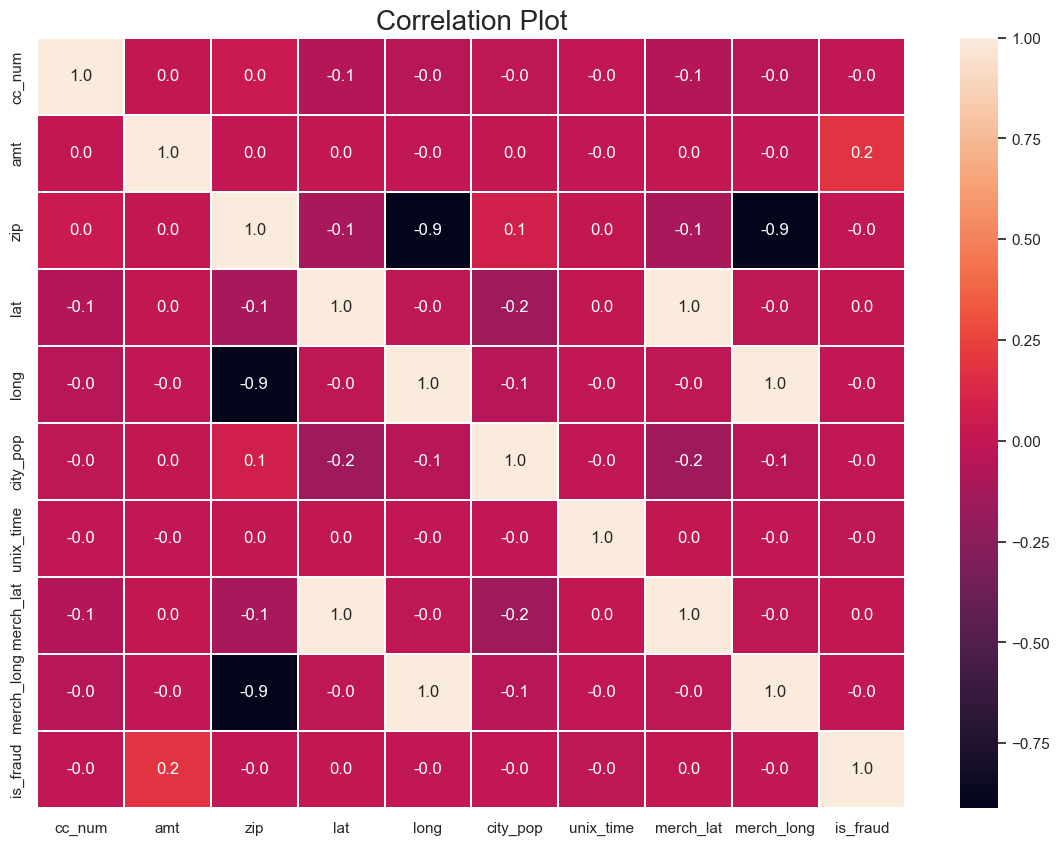

In [45]:
float_types_columns = []
for col in data:
    try:
        data[col].astype('float')
        float_types_columns.append(col)
    except:
        continue

plt.figure(figsize = (14,10))
plt.title('Correlation Plot', size = 20)
corr = data[float_types_columns].corr()
sns.set(rc={'figure.figsize':(13.7,8.27)})
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,fmt='.1f',annot=True)
plt.show()

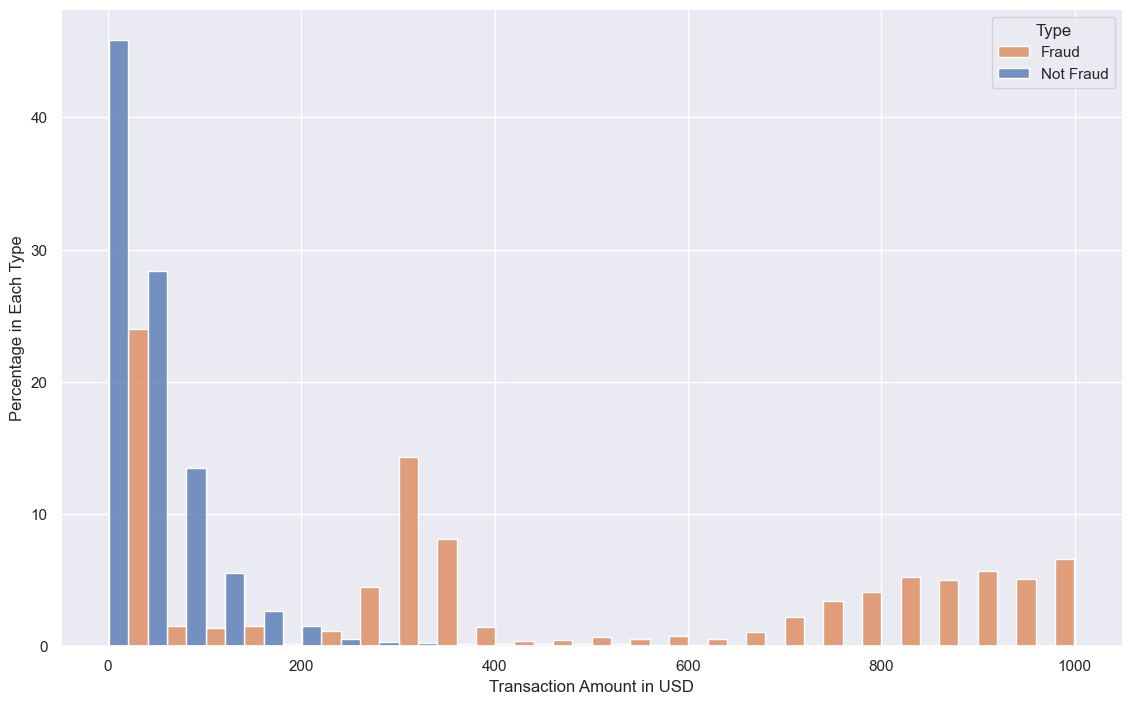

In [46]:
df = data
ax=sns.histplot(x='amt',data=df[df.amt<=1000],hue='is_fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount in USD')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

<Axes: xlabel='gender', ylabel='count'>

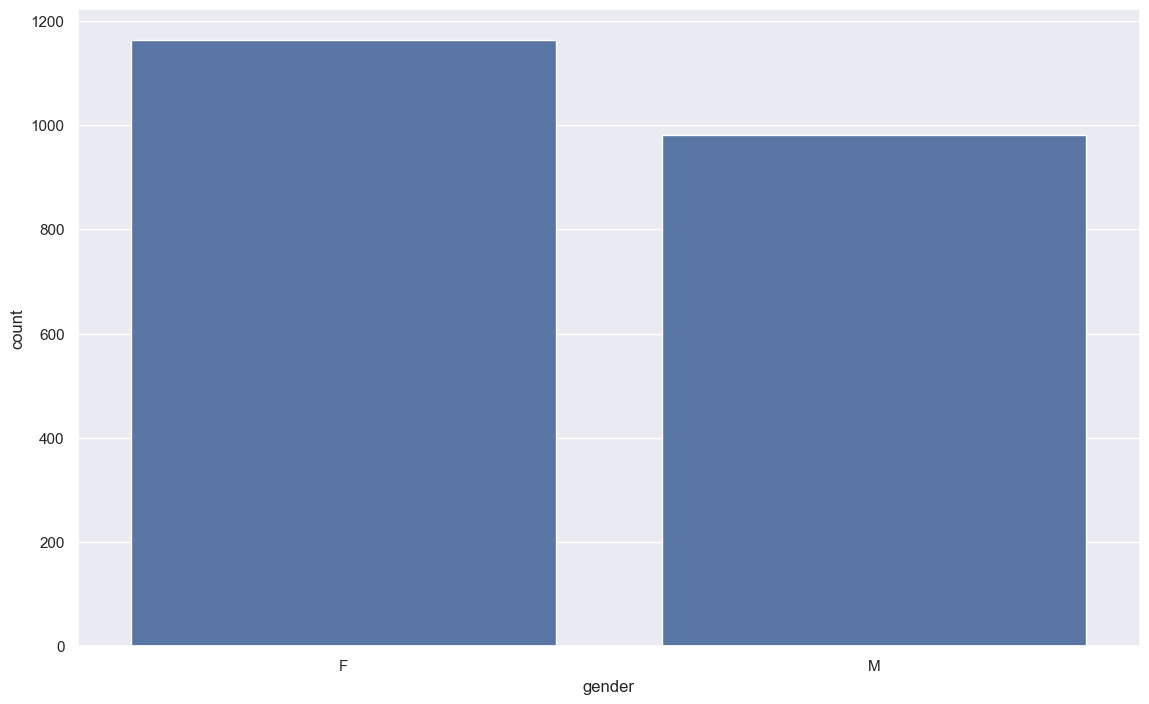

In [47]:
sns.countplot(x="gender",data=df[df["is_fraud"]==1])

<Axes: xlabel='age_group', ylabel='count'>

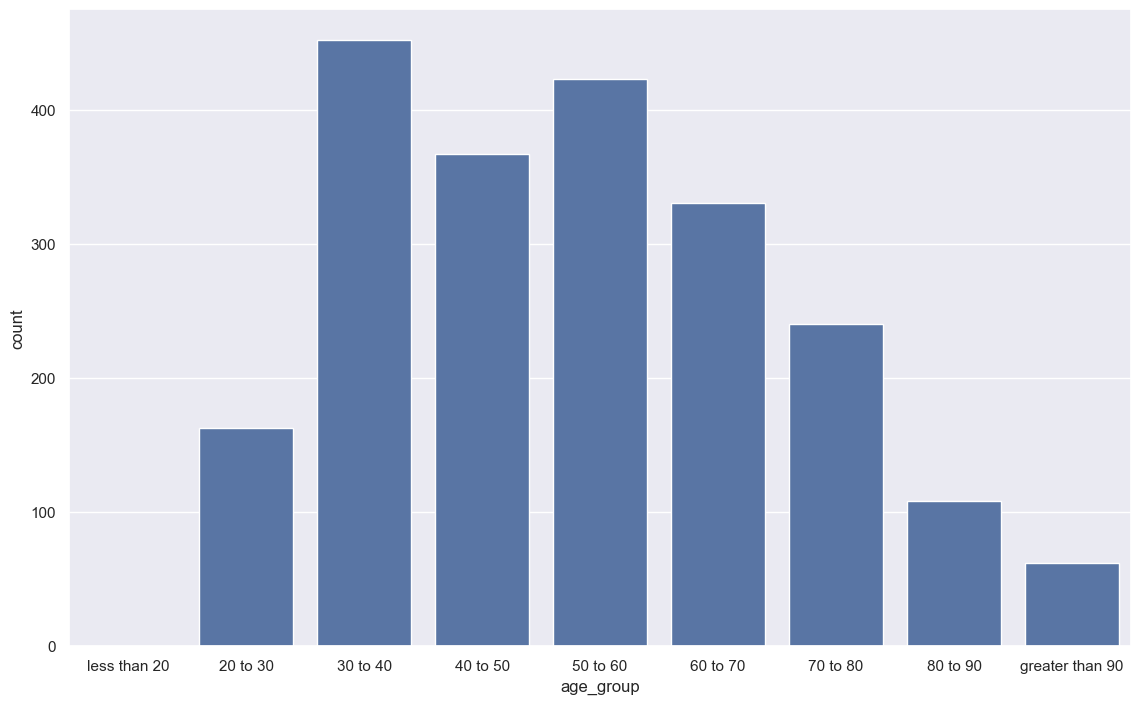

In [48]:
data['dob'] = pd.to_datetime(data['dob'])
data['age'] = (pd.Timestamp.today() - data['dob']).dt.days // 365

# Create age groups
def age_category(age):
    if age < 20:
        return "less than 20"
    elif age < 30:
        return "20 to 30"
    elif age < 40:
        return "30 to 40"
    elif age < 50:
        return "40 to 50"
    elif age < 60:
        return "50 to 60"
    elif age < 70:
        return "60 to 70"
    elif age < 80:
        return "70 to 80"
    elif age < 90:
        return "80 to 90"
    else:
        return "greater than 90"

# Create age group column
data['age_group'] = data['age'].apply(age_category)

order = ["less than 20","20 to 30","30 to 40","40 to 50","50 to 60","60 to 70","70 to 80","80 to 90","greater than 90"]
sns.countplot(x="age_group",data=df[df["is_fraud"]==1], order = order)

In [49]:
import numpy as np

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of earth in kilometers
    r = 6371
    
    return c * r

# Calculate distances and create new column
data['dist'] = haversine_distance(
    data['lat'], 
    data['long'], 
    data['merch_lat'], 
    data['merch_long']
)

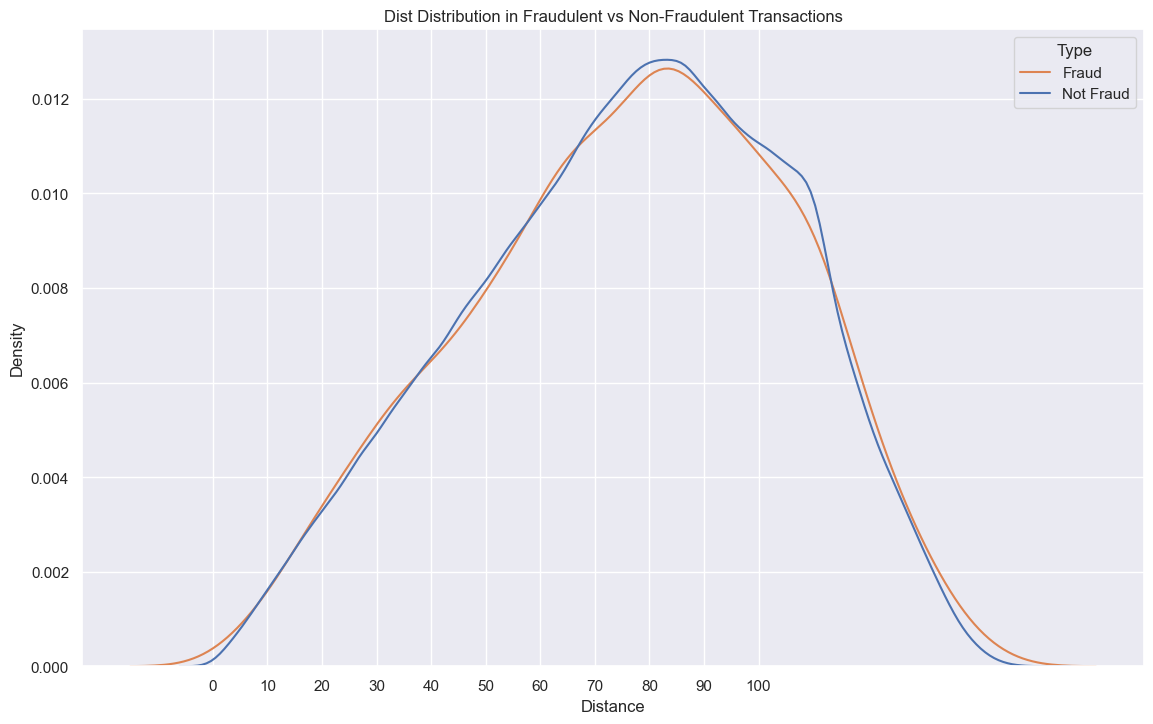

In [50]:
#Relation between distance vs fraud
import datetime as dt
import numpy as np
ax=sns.kdeplot(x='dist',data=df, hue='is_fraud', common_norm=False)
ax.set_xlabel('Distance')
ax.set_ylabel('Density')
plt.xticks(np.arange(0,110,10))
plt.title('Dist Distribution in Fraudulent vs Non-Fraudulent Transactions')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

<Axes: xlabel='state', ylabel='count'>

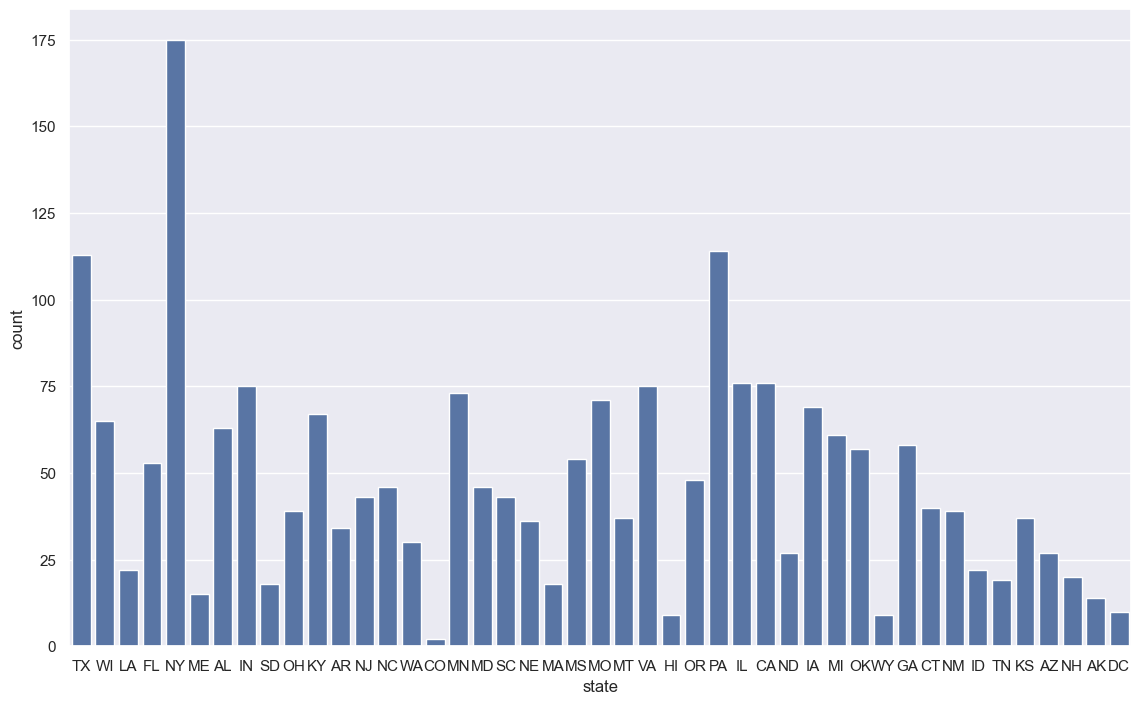

In [51]:
sns.countplot(x="state",data=df[df["is_fraud"]==1])

# Data Pre-processing

In [52]:
data.shape

(555719, 25)

In [53]:
data = data.drop(["lat","long","merch_lat","merch_long"], axis=1)
drop_cols = ["cc_num","merchant","first","last","street","trans_num","city_pop","job","unix_time","trans_num","city","zip"]
data = data.drop(columns = drop_cols, axis=1)

In [54]:
data.columns

Index(['trans_date_trans_time', 'category', 'amt', 'gender', 'state', 'dob',
       'is_fraud', 'age', 'age_group', 'dist'],
      dtype='object')

In [55]:
data['is_fraud'].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

In [56]:
non_fraud = data[data['is_fraud']==0]
fraud = data[data['is_fraud']==1]

In [57]:
non_fraud = non_fraud.sample(fraud.shape[0])
non_fraud.shape

(2145, 10)

In [58]:
data = pd.concat([non_fraud, fraud])

In [59]:
data['is_fraud'].value_counts()

is_fraud
0    2145
1    2145
Name: count, dtype: int64

In [60]:
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [61]:
def data_processing(data,encoding=True):
  if encoding:
    print('One Hot Encoding is applied')
    data = pd.concat([data,pd.get_dummies(data["gender"]),pd.get_dummies(data["age_group"]),pd.get_dummies(data["state"]),pd.get_dummies(data["category"])],axis=1)
    data = data.drop(["trans_date_trans_time", "dob", "gender","age_group","state","category"], axis=1)
  y = data["is_fraud"]
  x = data.drop(["is_fraud"], axis = 1)   

  # Standardization
  scaler = StandardScaler()
  x = scaler.fit_transform(x)
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)
  
  # If the training data imbalanced we’ll address this using Synthetic Minority Oversampling Technique (SMOTE). 
  # It is an oversampling technique that creates artificial minority class samples. 
  # In our case, it creates synthetic fraud instances and so corrects the imbalance in our dataset.
  # y_train.value_counts()
  if y_train.value_counts()[0] != y_train.value_counts()[1]:
    print('SMOTE is applied')
    X_train, y_train = SMOTE().fit_resample(X_train, y_train)
  return X_train, y_train, X_test, y_test, data  


In [62]:
X_train, y_train, X_test, y_test, processed_data = data_processing(data)
y_train.value_counts()

One Hot Encoding is applied
SMOTE is applied


is_fraud
1    1720
0    1720
Name: count, dtype: int64

In [63]:
features = processed_data.columns.drop('is_fraud')
features

Index(['amt', 'age', 'dist', 'F', 'M', '20 to 30', '30 to 40', '40 to 50',
       '50 to 60', '60 to 70', '70 to 80', '80 to 90', 'greater than 90', 'AK',
       'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'HI', 'IA', 'ID',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV',
       'WY', 'entertainment', 'food_dining', 'gas_transport', 'grocery_net',
       'grocery_pos', 'health_fitness', 'home', 'kids_pets', 'misc_net',
       'misc_pos', 'personal_care', 'shopping_net', 'shopping_pos', 'travel'],
      dtype='object')

In [64]:
X_train.shape

(3440, 77)

In [65]:
len(features)

77

In [66]:
data.columns

Index(['trans_date_trans_time', 'category', 'amt', 'gender', 'state', 'dob',
       'is_fraud', 'age', 'age_group', 'dist'],
      dtype='object')

# Model Building

## using scikit-learn

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, accuracy_score,mean_absolute_error
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

model_impl = RandomForestClassifier()
# X_train = X_train.reshape(X_train.shape[0],1)
# X_test = X_test.reshape(X_test.shape[0],1)
model_impl.fit(X_train,y_train)
pred_train=model_impl.predict(X_train)
pred_test=model_impl.predict(X_test)

accuracy_train = accuracy_score(pred_train,y_train)
accuracy_test = accuracy_score(pred_test,y_test)
confusionMatrix = confusion_matrix(y_test,pred_test)
classificationReport = classification_report(y_test,pred_test)
mae = mean_absolute_error(y_train,pred_train)
# print("Model Implemented: ", 'Decision_tree')
print("Accuracy on Training Set: ", accuracy_train)
print('Accuracy on Validation Set: ', accuracy_test)
print('Mean absolute error: ',mae)
print('Confusion Matrix\n', confusionMatrix)
print('Classification Report\n', classificationReport)

(3440, 77) (3440,) (858, 77) (858,)
Accuracy on Training Set:  1.0
Accuracy on Validation Set:  0.9557109557109557
Mean absolute error:  0.0
Confusion Matrix
 [[415  10]
 [ 28 405]]
Classification Report
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       425
           1       0.98      0.94      0.96       433

    accuracy                           0.96       858
   macro avg       0.96      0.96      0.96       858
weighted avg       0.96      0.96      0.96       858



## using Tensorflow 

In [68]:
epochs = 50
model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())

model.add(Conv1D(32, 2, activation='elu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [69]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 76, 64)            192       
                                                                 
 batch_normalization_1 (Batc  (None, 76, 64)           256       
 hNormalization)                                                 
                                                                 
 conv1d_3 (Conv1D)           (None, 75, 32)            4128      
                                                                 
 dropout_2 (Dropout)         (None, 75, 32)            0         
                                                                 
 dense_3 (Dense)             (None, 75, 64)            2112      
                                                                 
 flatten_1 (Flatten)         (None, 4800)              0         
                                                      

In [70]:
model.compile(optimizer=Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [71]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=1,callbacks = [callback])

Epoch 1/50
108/108 [==============================] - 2s 14ms/step - loss: 0.5424 - accuracy: 0.7102 - val_loss: 0.5493 - val_accuracy: 0.8019
Epoch 2/50
108/108 [==============================] - 1s 12ms/step - loss: 0.3597 - accuracy: 0.8375 - val_loss: 0.4270 - val_accuracy: 0.8298
Epoch 3/50
108/108 [==============================] - 1s 11ms/step - loss: 0.3170 - accuracy: 0.8506 - val_loss: 0.3489 - val_accuracy: 0.8450
Epoch 4/50
108/108 [==============================] - 1s 11ms/step - loss: 0.2828 - accuracy: 0.8660 - val_loss: 0.3260 - val_accuracy: 0.8380
Epoch 5/50
108/108 [==============================] - 1s 10ms/step - loss: 0.2682 - accuracy: 0.8648 - val_loss: 0.3041 - val_accuracy: 0.8368
Epoch 6/50
108/108 [==============================] - 1s 12ms/step - loss: 0.2494 - accuracy: 0.8712 - val_loss: 0.2656 - val_accuracy: 0.8613
Epoch 7/50
108/108 [==============================] - 1s 13ms/step - loss: 0.2399 - accuracy: 0.8782 - val_loss: 0.2801 - val_accuracy: 0.8671

In [72]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

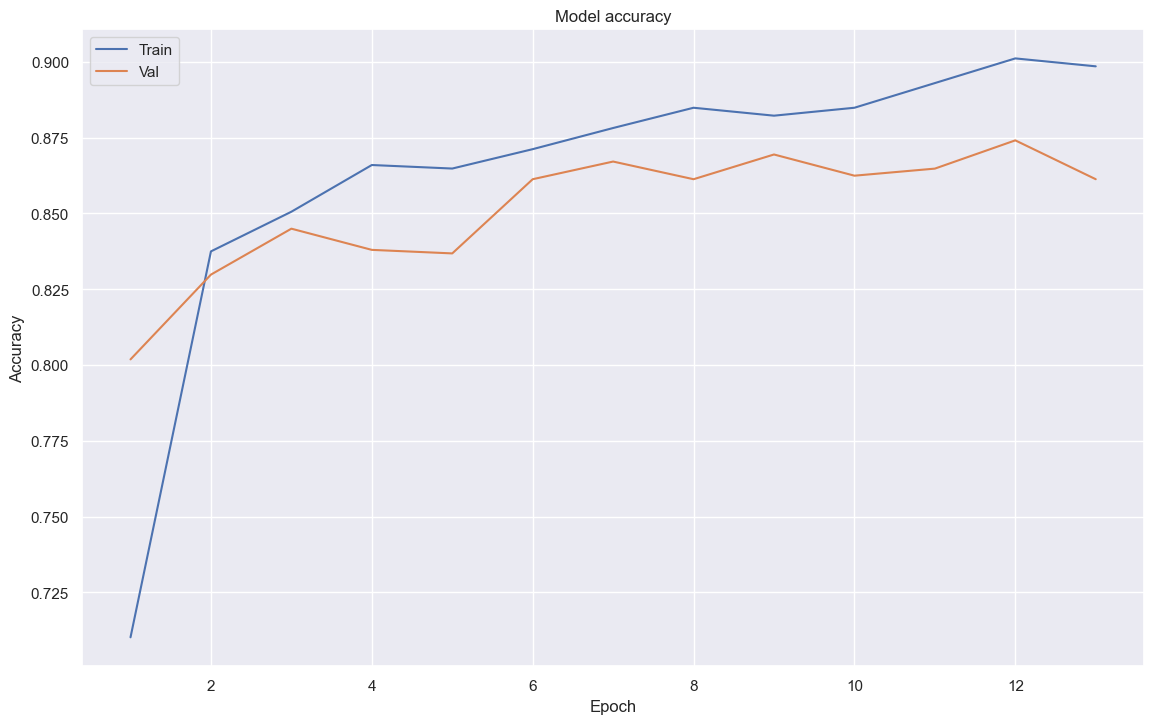

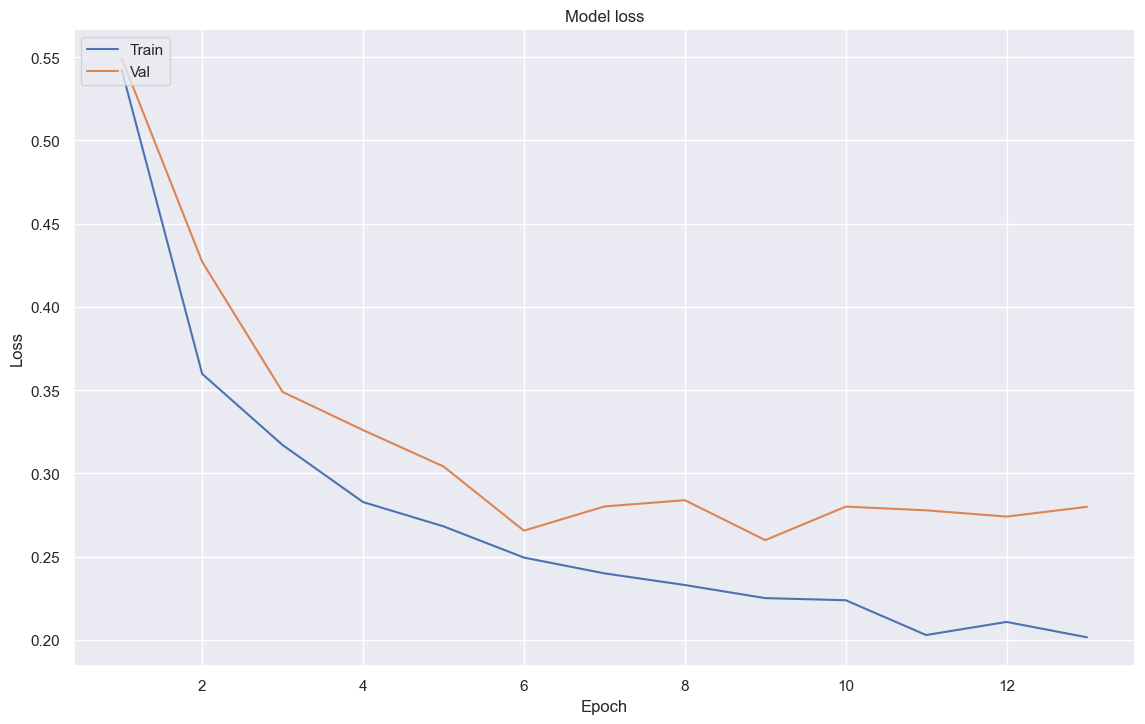

In [73]:
plot_learningCurve(history,len(history.epoch))

In [74]:
y_predict = model.predict(X_test)

27/27 [==============================] - 0s 6ms/step


In [75]:
classificationReport = classification_report(y_test, np.round(y_predict).astype(int))
print(classificationReport)

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       425
           1       0.95      0.78      0.86       433

    accuracy                           0.87       858
   macro avg       0.88      0.87      0.87       858
weighted avg       0.88      0.87      0.87       858



In [76]:
confusionMatrix = confusion_matrix(y_test, np.round(y_predict).astype(int))
confusionMatrix

array([[408,  17],
       [ 95, 338]], dtype=int64)

# XAI Techniques

In [77]:
import shap
from sklearn.metrics import roc_auc_score, accuracy_score

# # Suppress TensorFlow warnings
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# # Disable eager execution
# tf.compat.v1.disable_eager_execution()

## SHAP

### Get SHAP values

Using `DeepExplainer`(specifcifically for neural networks)

**For `DeepExplainer`, we need to create a `background` dataset**: This is because deep neural networks are complex and non-linear, so they require reference points (background samples) to understand how the model normally behaves and accurately calculate feature importance.

Passing the entire training dataset as data will give very accurate expected values, but be unreasonably expensive. The variance of the expectation estimates scale by roughly `1/sqrt(N)` for `N` background data samples. 

So 100 samples will give a good estimate, and 1000 samples a very good estimate of the expected values.

In [78]:
def SHAP(model, X_train, X_test, from_idx, to_idx, background_size=100):
    X_train = np.expand_dims(X_train, axis=-1) if X_train.shape[-1] != 1 else X_train
    X_test = np.expand_dims(X_test, axis=-1) if X_test.shape[-1] != 1 else X_test
    
    background = X_train[np.random.choice(len(X_train), background_size, replace=False)]
    
    explainer = shap.DeepExplainer(model, background)
    
    shap_values = explainer.shap_values(X_test[from_idx:to_idx+1]) # Deep learning models expect 2D input arrays (samples × features), X_test[idx] only returns a 1D array (shape: (n_features,)

    shap_values = shap_values.squeeze()[np.newaxis, ...] if shap_values.shape[0] == 1 else shap_values.squeeze()
    
    return explainer, shap_values

### Global Interpretability (whole test set)

In [79]:
# Call the function to obtain SHAP values.
from_idx = 0
# to_idx = 50
to_idx = len(X_test)-1

explainer, shap_values = SHAP(model, X_train, X_test, from_idx, to_idx, background_size=100)
shap_values.shape

d:\ThongLai\OneDrive - University of Huddersfield\FYP\code\Credit-Card-Transaction-Fraud-Detection-Using-Explainable-AI\.venv_xai_fraud_detection\lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
d:\ThongLai\OneDrive - University of Huddersfield\FYP\code\Credit-Card-Transaction-Fraud-Detection-Using-Explainable-AI\.venv_xai_fraud_detection\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


(858, 77)

In [80]:
def get_top_n_features(shap_values, features, n=10):
    mean_shap_values = np.abs(shap_values).mean(axis=0)

    df_shap = pd.DataFrame({
        'feature': features,
        'mean_abs_shap': np.squeeze(mean_shap_values)
    }).set_index('feature')

    df_shap = df_shap.reindex(df_shap['mean_abs_shap'].abs().sort_values(ascending=False).index)

    # Get top n features
    n = 10
    top_n_features = list(df_shap.head(n).index)

    display(df_shap.head(n))

    return top_n_features

top_n_features = get_top_n_features(shap_values, features, n=10)

mean_abs_shap
feature                     
amt                 0.339822
age                 0.022143
shopping_net        0.016113
grocery_pos         0.014833
F                   0.014278
shopping_pos        0.014108
entertainment       0.012981
gas_transport       0.011682
misc_net            0.011364
M                   0.011120

### Visualization
[SHAP Plots Explained](https://www.youtube.com/playlist?list=PLpoCVQU4m6j9HDOzRBL4nX4eol9DrZ3Kd)

#### Summary Plot

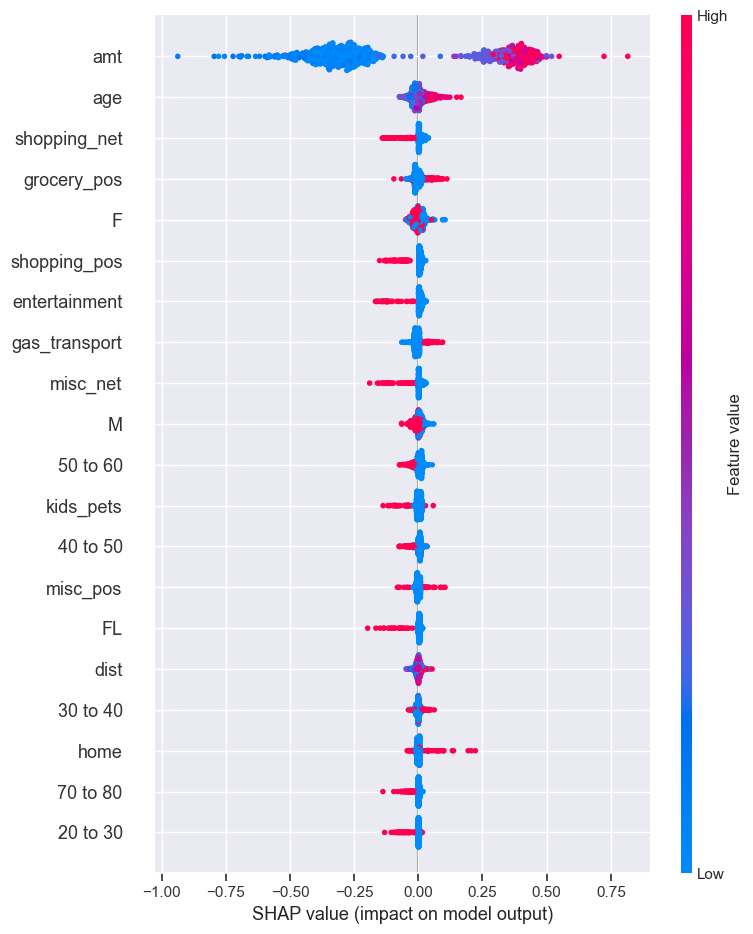

In [81]:
shap.summary_plot(shap_values, X_test[from_idx:to_idx+1], features)

#### Force Plot

[How to use Shapley Additive Explanations for Black Box Machine Learning Algorithms](https://www.youtube.com/watch?v=7wnG6Wnm2uU)

In [82]:
# Plot feature contributions for a prediction
shap.initjs()
baseline = explainer.expected_value.numpy()

shap.force_plot(baseline, shap_values, processed_data.loc[y_test.index].drop('is_fraud', axis=1).iloc[from_idx:to_idx+1], features)

#### Single Feature Partial Dependence Plot

[How to Build Shap Single Feature Partial Dependence Plot (PDP Plot)](https://www.youtube.com/watch?v=CgKyAlA-0wA)

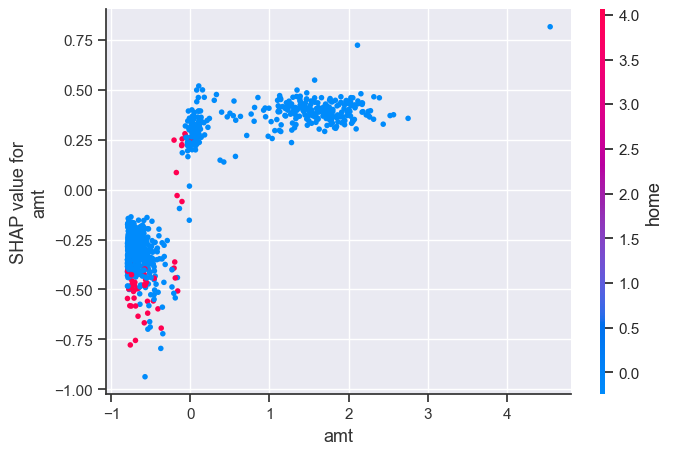

In [83]:
# Dependence plot for specific feature
shap.dependence_plot("amt", shap_values, X_test[from_idx:to_idx+1], features)

In [84]:
fraud_data = processed_data[processed_data['is_fraud'] == 1]
non_fraud_data = processed_data[processed_data['is_fraud'] == 0]

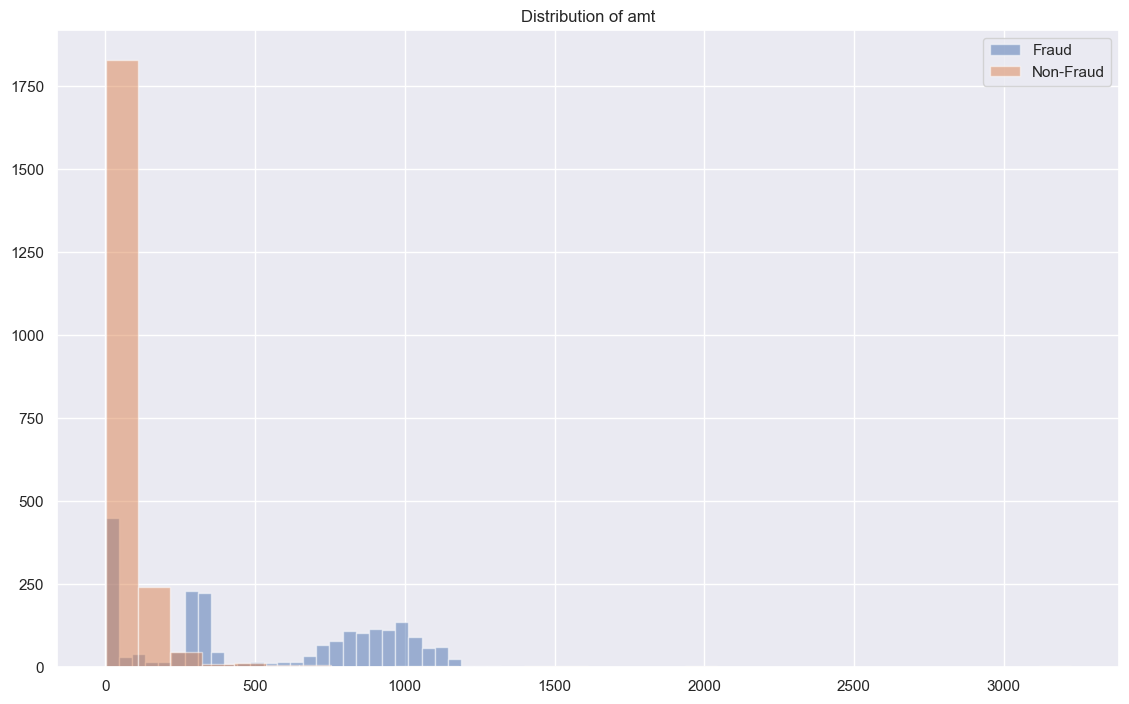

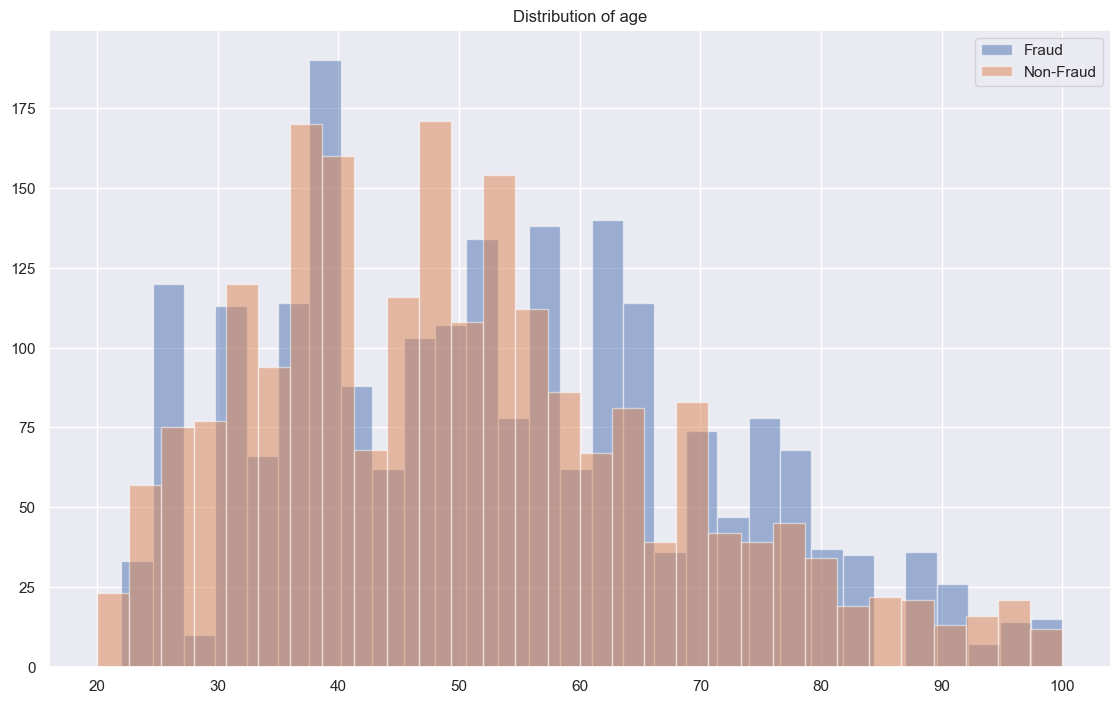

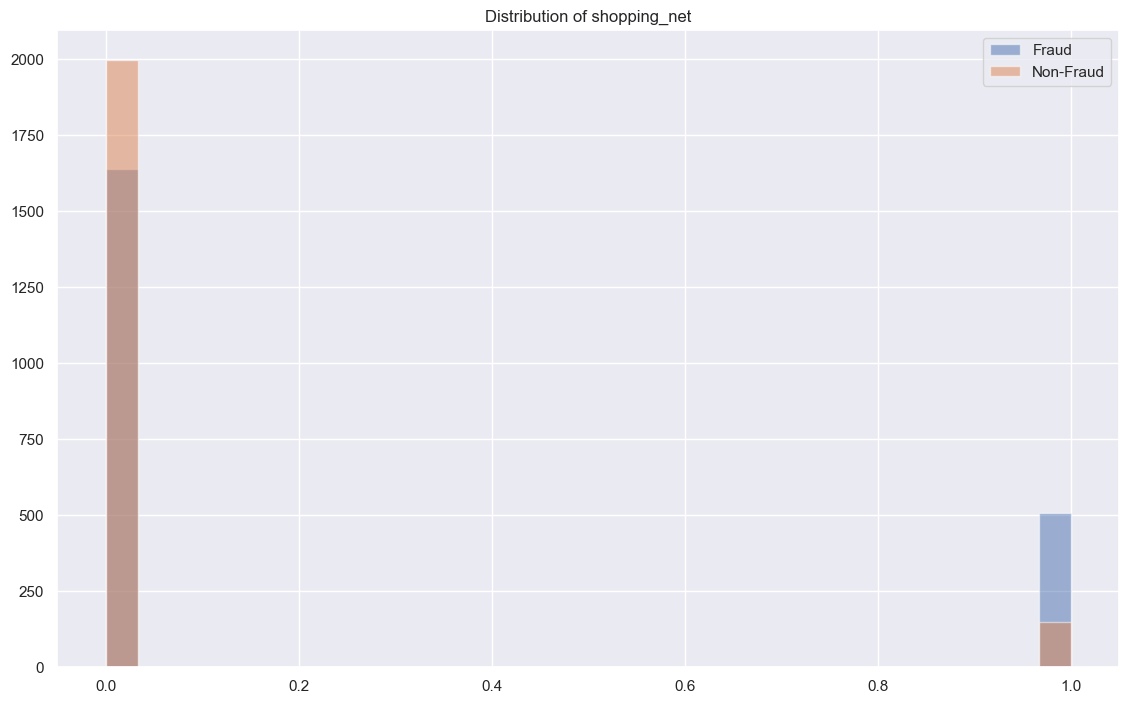

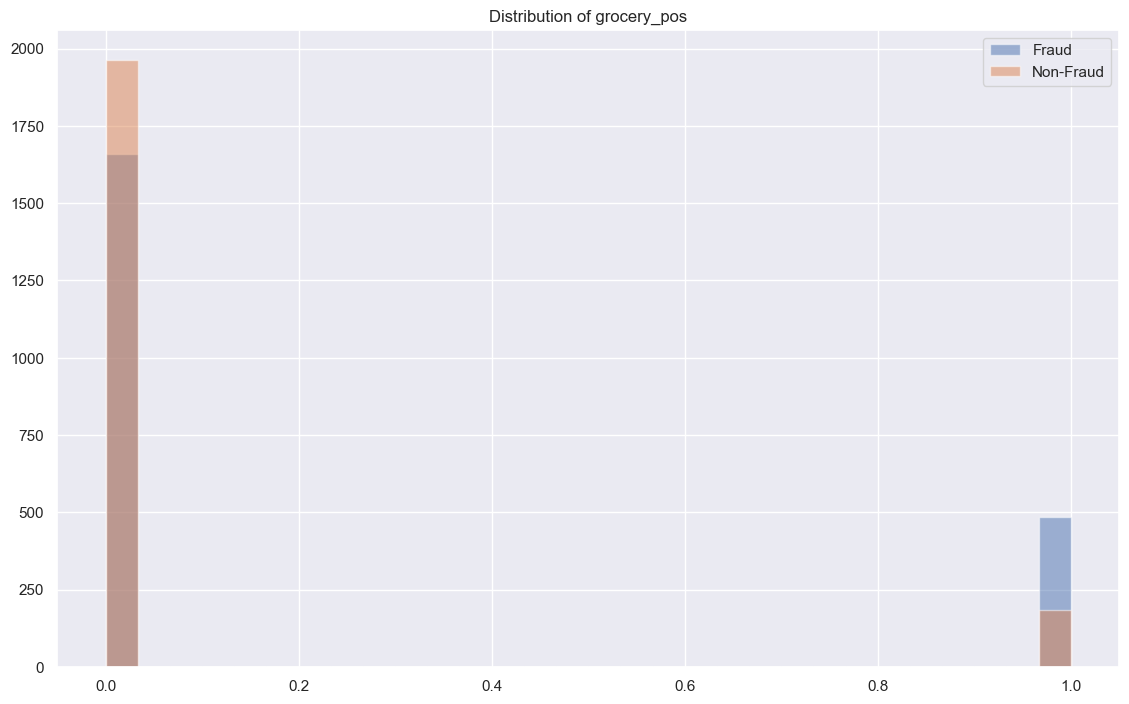

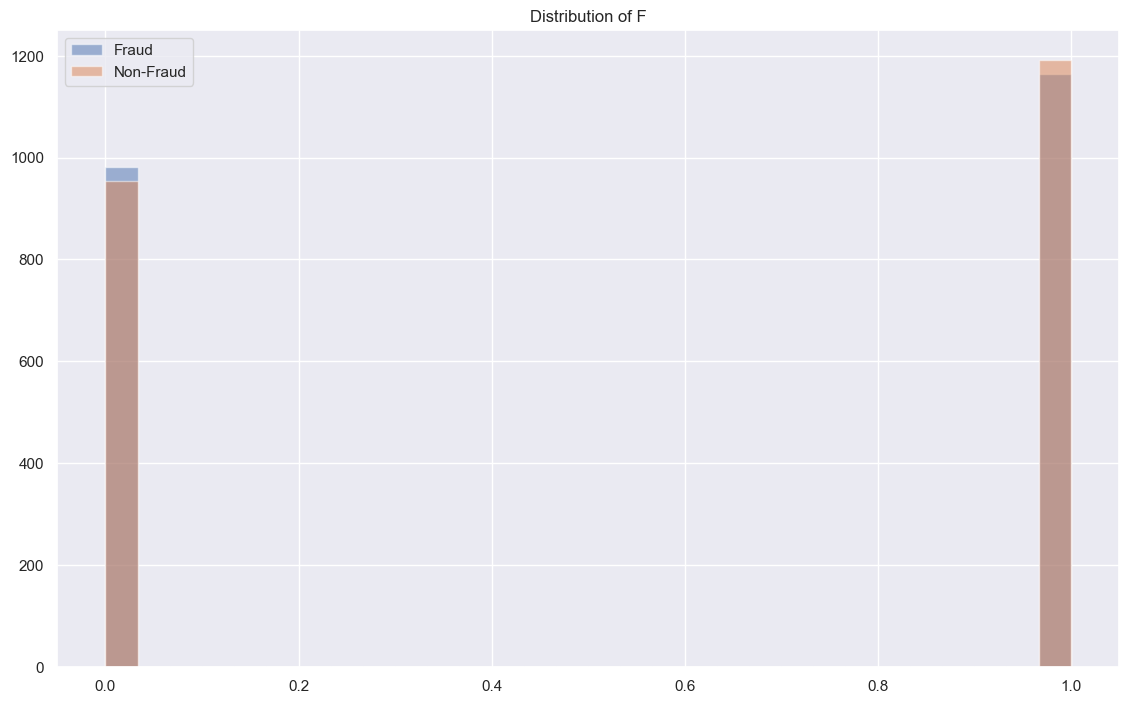

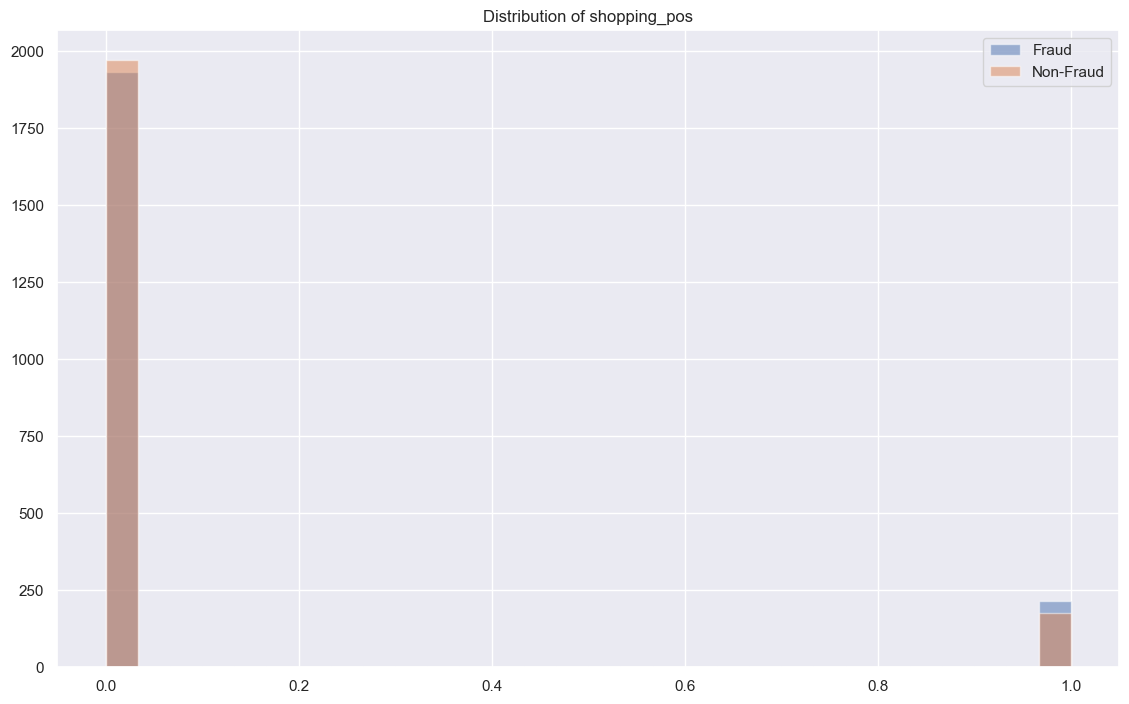

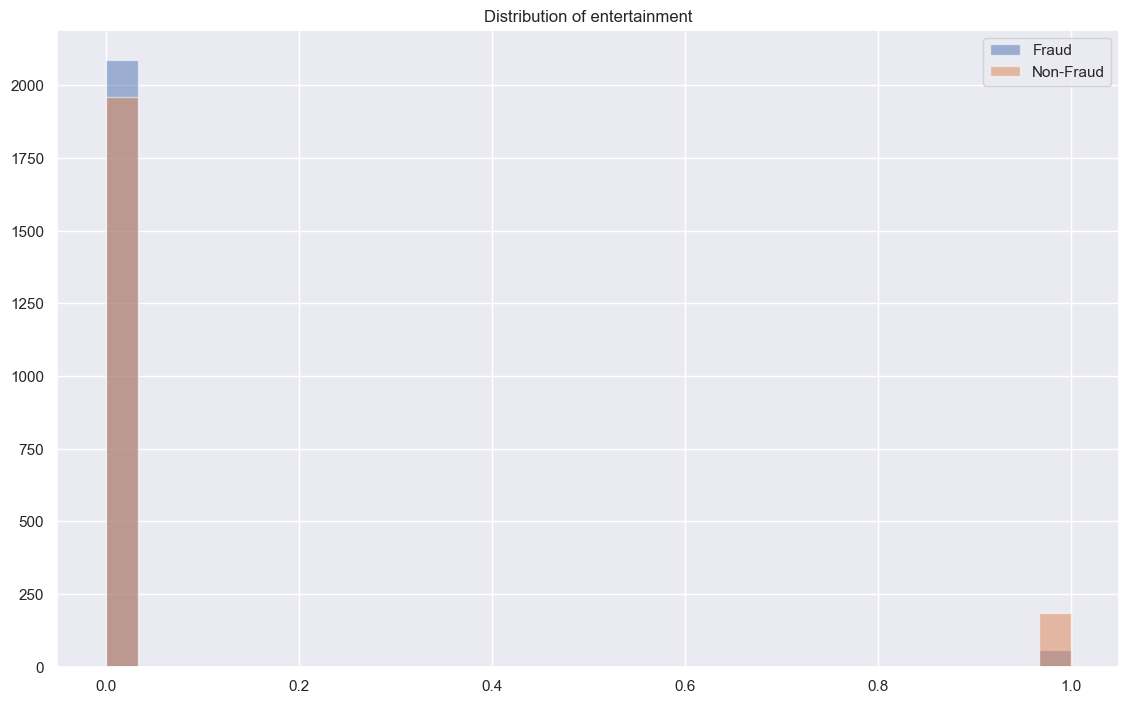

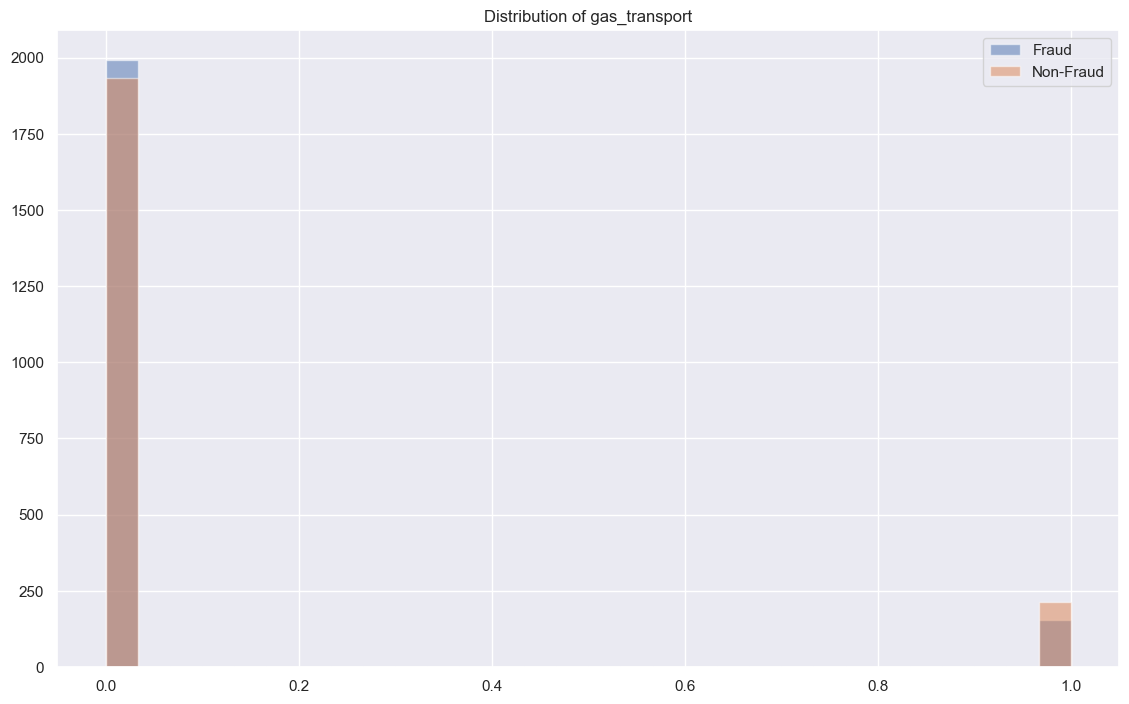

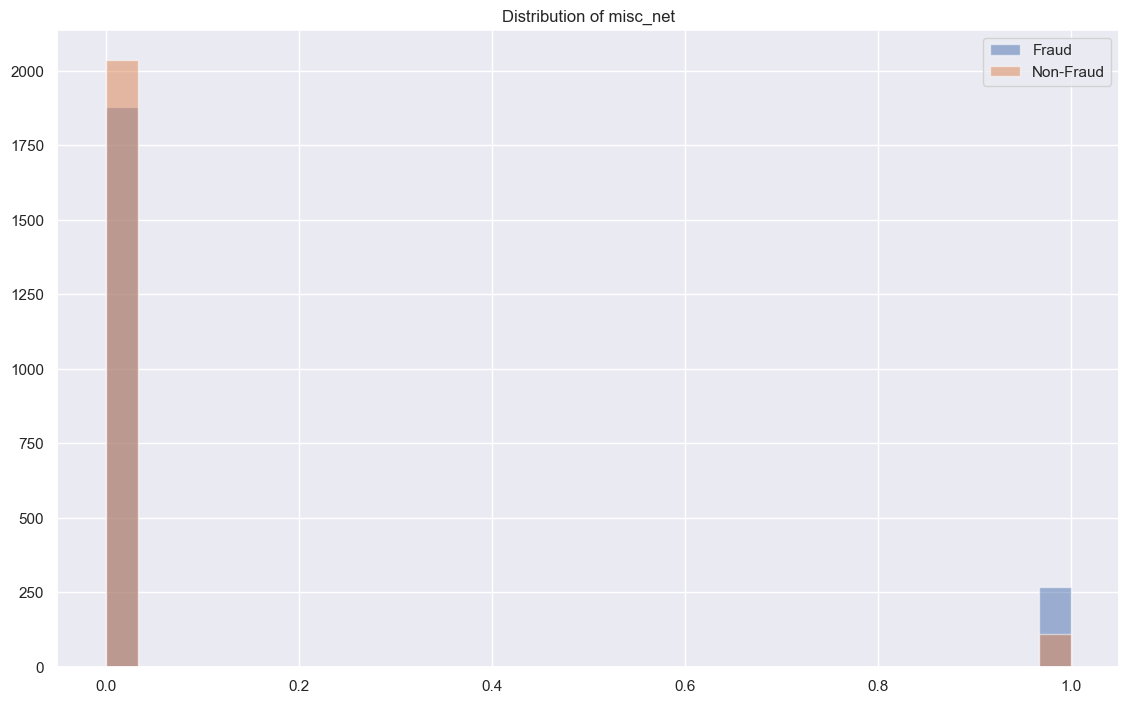

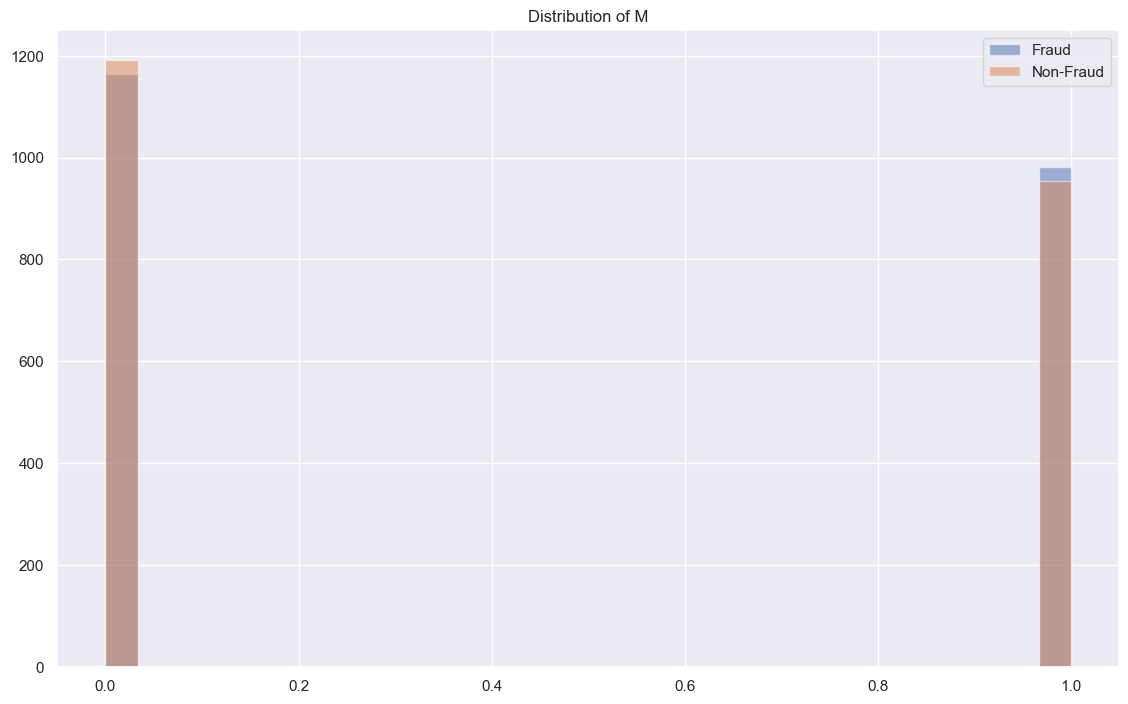

In [85]:
# Statistical analysis of top n features
for feature in top_n_features:
    plt.hist(fraud_data[feature].astype(int), alpha=0.5, label='Fraud', bins=30)
    plt.hist(non_fraud_data[feature].astype(int), alpha=0.5, label='Non-Fraud', bins=30)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()

Text(0.5, 1.0, 'Distribution of `amt` Above Mean of Dataset (297.54)')

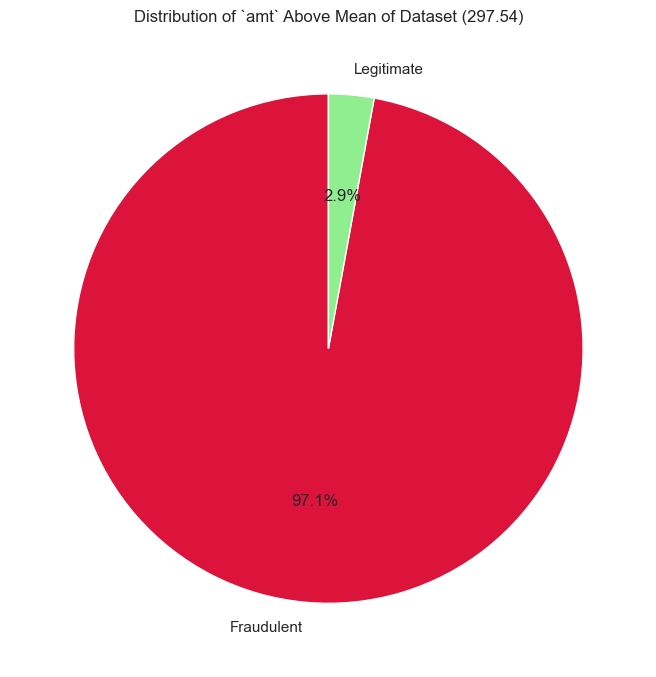

In [86]:
feature = 'amt'
mean_value = processed_data[feature].mean()

fraud_ratio = len(fraud_data[fraud_data[feature] > mean_value]) * 100 / len(processed_data[processed_data[feature] > mean_value])
legitimate_ratio = 100 - fraud_ratio

plt.pie([fraud_ratio, legitimate_ratio], 
        labels=['Fraudulent', 'Legitimate'], 
        colors=['crimson', 'lightgreen'], 
        autopct='%1.1f%%', startangle=90)
plt.title(f'Distribution of `{feature}` Above Mean of Dataset ({mean_value:.2f})')

Text(0.5, 1.0, 'Distribution of `shopping_net` Transactions Above Mean of Dataset (297.54)')

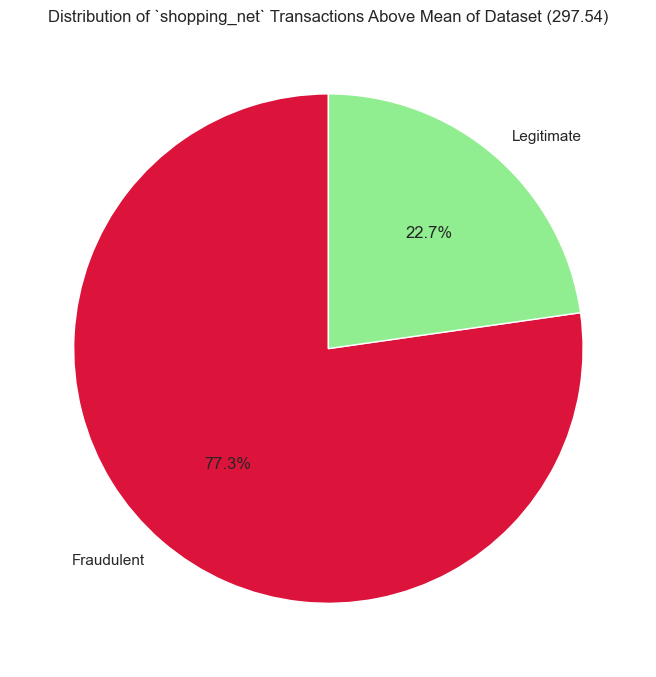

In [87]:
feature = 'shopping_net'

fraud_ratio = len(fraud_data[fraud_data[feature]]) * 100 / len(processed_data[processed_data[feature]])
legitimate_ratio = 100 - fraud_ratio

plt.pie([fraud_ratio, legitimate_ratio], 
        labels=['Fraudulent', 'Legitimate'], 
        colors=['crimson', 'lightgreen'], 
        autopct='%1.1f%%', startangle=90)
plt.title(f'Distribution of `{feature}` Transactions Above Mean of Dataset ({mean_value:.2f})')

Text(0.5, 1.0, 'Distribution of `grocery_pos` Transactions Above Mean of Dataset (297.54)')

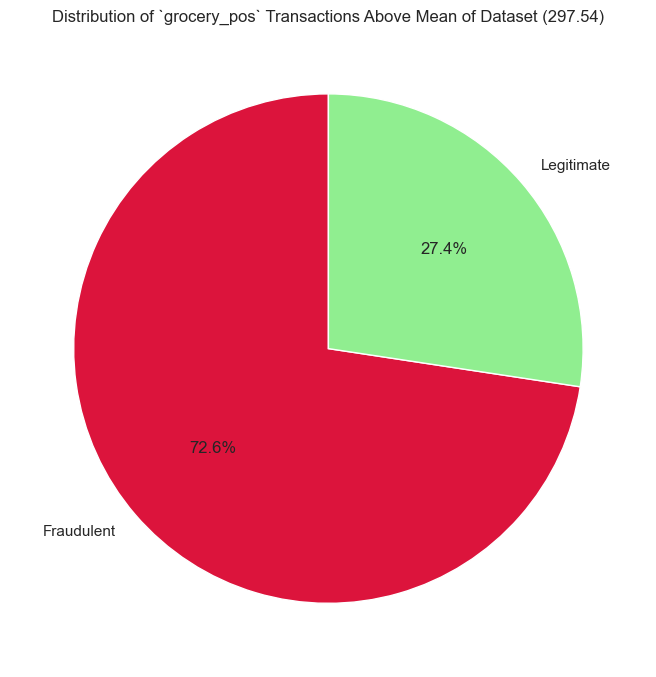

In [88]:
feature = 'grocery_pos'

fraud_ratio = len(fraud_data[fraud_data[feature]]) * 100 / len(processed_data[processed_data[feature]])
legitimate_ratio = 100 - fraud_ratio

plt.pie([fraud_ratio, legitimate_ratio], 
        labels=['Fraudulent', 'Legitimate'], 
        colors=['crimson', 'lightgreen'], 
        autopct='%1.1f%%', startangle=90)
plt.title(f'Distribution of `{feature}` Transactions Above Mean of Dataset ({mean_value:.2f})')

Text(0.5, 1.0, 'Distribution of `gas_transport` Transactions Above Mean of Dataset (297.54)')

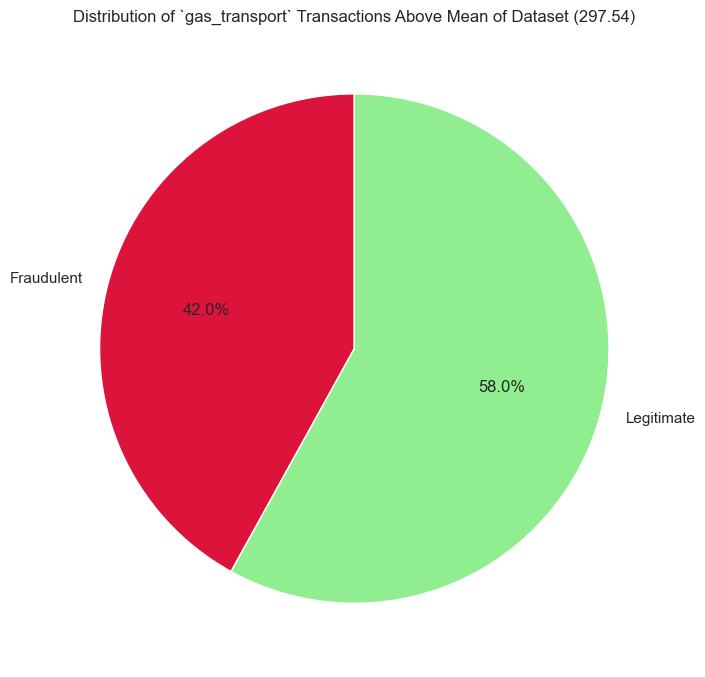

In [89]:
feature = 'gas_transport'

fraud_ratio = len(fraud_data[fraud_data[feature]]) * 100 / len(processed_data[processed_data[feature]])
legitimate_ratio = 100 - fraud_ratio

plt.pie([fraud_ratio, legitimate_ratio], 
        labels=['Fraudulent', 'Legitimate'], 
        colors=['crimson', 'lightgreen'], 
        autopct='%1.1f%%', startangle=90)
plt.title(f'Distribution of `{feature}` Transactions Above Mean of Dataset ({mean_value:.2f})')

Text(0.5, 1.0, 'Distribution of `misc_net` Transactions Above Mean of Dataset (297.54)')

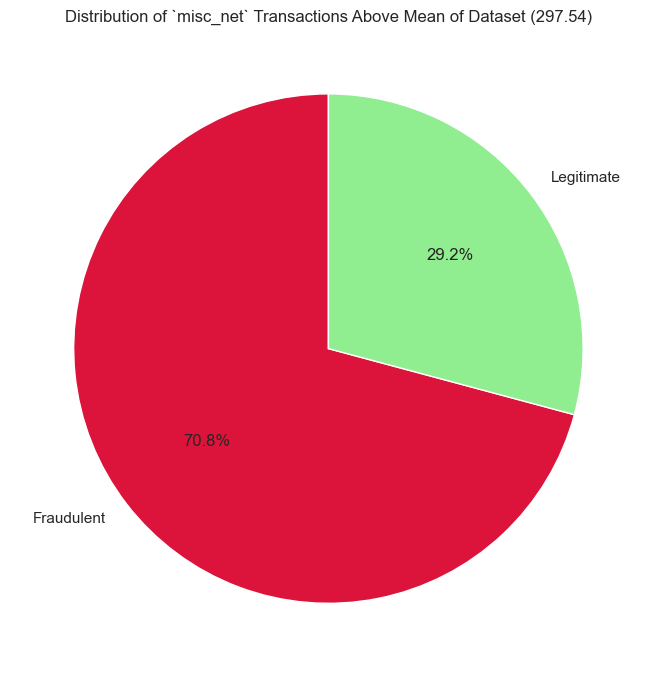

In [90]:
feature = 'misc_net' # Miscellaneous online transactions

fraud_ratio = len(fraud_data[fraud_data[feature]]) * 100 / len(processed_data[processed_data[feature]])
legitimate_ratio = 100 - fraud_ratio

plt.pie([fraud_ratio, legitimate_ratio], 
        labels=['Fraudulent', 'Legitimate'], 
        colors=['crimson', 'lightgreen'], 
        autopct='%1.1f%%', startangle=90)
plt.title(f'Distribution of `{feature}` Transactions Above Mean of Dataset ({mean_value:.2f})')

#### Feature Ablation Study

In [91]:

def feature_ablation_study_global(model, X, y, from_idx, to_idx, selected_features, all_features):
    global replacement_values, ablated_pred
    base_pred = model.predict(X, verbose=0)
    base_auc = roc_auc_score(y, base_pred)
    
    # Precompute replacement values for each feature to avoid repeated computation.
    replacement_values = {}
    for idx, feature in enumerate(all_features):
        replacement_values[feature] = np.median(X[:, idx])

    print(f"Global (AUC) Feature Ablation Study from index [{from_idx}] to index [{to_idx}]:")
    test_set = X[from_idx:to_idx+1]
    records = []
    for idx, feature in enumerate(all_features):
        X_temp = test_set.copy()
        X_temp[:, idx] = replacement_values[feature]
        
        ablated_pred = model.predict(X_temp, verbose=0)
        ablated_auc = roc_auc_score(y[from_idx:to_idx+1], ablated_pred)
        
        impact = ((base_auc - ablated_auc) / base_auc) * 100
        
        records.append({
            'feature': feature,
            'ablation_auc': ablated_auc,
            'impact_score': impact
        })

    df_results = pd.DataFrame(records).sort_values(by='impact_score', ascending=False, key=abs).reset_index(drop=True)
    df_results['ranking'] = df_results.index+1  # Ranking: 1 denotes the highest impact.
    df_results = df_results[df_results['feature'].isin(selected_features)].reset_index(drop=True)
    
    return df_results

In [92]:
df_ablation_global = feature_ablation_study_global(model, X_test, y_test, from_idx, to_idx, top_n_features, features) 
df_ablation_global

Global (AUC) Feature Ablation Study from index [0] to index [857]:


feature  ablation_auc  impact_score  ranking
0            amt      0.434862     54.375818        1
1  gas_transport      0.943391      1.022796        2
2    grocery_pos      0.944961      0.858031        3
3              F      0.946086      0.740016        4
4              M      0.947523      0.589220        6
5            age      0.948396      0.497715        7
6  entertainment      0.950526      0.274228       11
7       misc_net      0.951428      0.179588       15
8   shopping_net      0.951884      0.131698       26
9   shopping_pos      0.951901      0.129987       27

### Local Interterpretation

In [93]:
def feature_ablation_single_entry(model, data_entry, selected_features, all_features):
    baseline_values = np.zeros_like(data_entry)
    
    original_prediction = model.predict(data_entry.reshape(1, -1), verbose=0)
    
    print(f"Local Feature Ablation Study: ")
    records = []
    for i, feature in enumerate(all_features):
        ablated_entry = data_entry.copy()
        ablated_entry[i] = baseline_values[i]
        
        ablated_pred = model.predict(ablated_entry.reshape(1, -1), verbose=0) # Compute prediction on the ablated entry
        
        impact = original_prediction - ablated_pred # Calculate the drop (or change) in prediction

        records.append({
            'feature': feature,
            'ablation_auc': ablated_pred.squeeze(),
            'impact_score': impact.squeeze()
        })
          
    df_results = pd.DataFrame(records).sort_values(by='impact_score', ascending=False, key=abs).reset_index(drop=True)
    df_results['ranking'] = df_results.index+1  # Ranking: 1 denotes the highest impact.
    df_results = df_results[df_results['feature'].isin(selected_features)].reset_index(drop=True)
    
    return df_results, original_prediction


In [94]:
idx = 2
df_ablation_local, original_prob = feature_ablation_single_entry(model, X_test[idx], top_n_features, features)
df_ablation_local

Local Feature Ablation Study: 


feature ablation_auc    impact_score  ranking
0            amt   0.32820573       0.6716511        1
1    grocery_pos   0.99997985  -0.00012302399        7
2       misc_net     0.999949   -9.214878e-05        9
3              M   0.99993527   -7.843971e-05       11
4   shopping_net   0.99990714   -5.030632e-05       18
5              F   0.99980813   4.8696995e-05       19
6  entertainment    0.9998988   -4.196167e-05       22
7  gas_transport   0.99987745  -2.0623207e-05       41
8   shopping_pos    0.9998747  -1.7881393e-05       46
9            age    0.9998727  -1.5854836e-05       51

In [95]:
# Plot feature contributions for a prediction
shap.initjs()
baseline = explainer.expected_value.numpy()

shap.force_plot(baseline, shap_values[idx:idx+1], processed_data.loc[y_test.index].drop('is_fraud', axis=1).iloc[idx:idx+1], features)

# LIME

In [96]:
# TO DO

## Not Active Codes

```
def feature_ablation_study_local(model, X, y, index, selected_features, all_features):
    global records, base_pred, base_diff, ablated_diff
    base_pred = model.predict(X[index:index+1], verbose=0)
    base_diff = y[index:index+1].to_numpy() - base_pred
    
    # Precompute replacement values for each feature to avoid repeated computation.
    replacement_values = {}
    for idx, feature in enumerate(all_features):
        replacement_values[feature] = np.median(X[:, idx])

    print(f"Local Feature Ablation Study of index [{index}]:")
    test_set = X[index:index+1]
    records = []
    for idx, feature in enumerate(all_features):
        X_temp = test_set.copy()
        X_temp[:, idx] = replacement_values[feature]
        
        ablated_pred = model.predict(X_temp, verbose=0)
        ablated_diff = y[index:index+1].to_numpy() - ablated_pred
        
        impact = np.mean(base_diff - ablated_diff / base_diff)
        
        records.append({
            'feature': feature,
            'ablation_diff': np.mean(ablated_diff),
            'impact_score': impact
        })

    df_results = pd.DataFrame(records).sort_values(by='impact_score', ascending=False, key=abs).reset_index(drop=True)
    df_results['ranking'] = df_results.index+1  # Ranking: 1 denotes the highest impact.
    
    df_results = df_results[df_results['feature'].isin(selected_features)].reset_index(drop=True)
    
    return df_results

df_ablation_local = feature_ablation_study_local(model, X_test, y_test, 2, top_n_features, features) 
df_ablation_local

```